### Import libraries

In [21]:
import pandas as pd

import string
from typing import Tuple

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, DateFormatter

import seaborn as sns
import numpy as np

import math
from math import acos, pi

import sklearn
from sklearn import datasets                      # To import the sample dataset
from sklearn.preprocessing import StandardScaler  # To transform the dataset
from sklearn.cluster import KMeans                # To instantiate, train and use model
from sklearn import metrics    

import datetime
from datetime import datetime,timedelta

from scipy import stats
import array as arr
from sklearn.metrics import r2_score

import statistics 
import plotly.express as px

import kaleido
import os

if not os.path.exists("images"):
    os.mkdir("images")


import plotly



### Read dataframe

In [22]:
read_datetime='all' #yy-mm, all
data={}

for x in range(9):
        df=pd.read_csv(r"C:\Users\meulo\Desktop\plants\plant_"+str(x+1)+".csv",delimiter=';',decimal=',',encoding='latin-1')
        df.iloc[:,0]= pd.to_datetime(df.iloc[:,0], format='%d/%m/%Y %H:%M')
        for a in range(df.shape[0]):
            for b in range(df.shape[1]-1):
                df.iloc[a,b+1]=df.iloc[a,b+1].replace(',', '.')
        df=df.replace("n/d",np.NaN)
        for a in range(df.shape[1]-1):
            df.iloc[:,a+1] = pd.to_numeric(df.iloc[:,a+1])
        data[x] = df

if read_datetime != 'all':
    for i in range(9):
        data[i]["Datetime"] = pd.to_datetime(data[i]["Datetime"])
        data[i]["Period"]=data[i]["Datetime"].dt.strftime('%y-%m')
        data[i] = data[i].loc[data[i]["Period"] == read_datetime]
        data[i] = data[i].drop("Period",axis=1)

# Plot Data

Plot monitoring data, one graph for each monitoring station: there are a total of 9 monitoring stations, detecting pH, temperature, condictivity and redox potential, from January 1 2023 to November 7 2023. Flat lines represent lost signal, which will be detected and deleted later on in the code

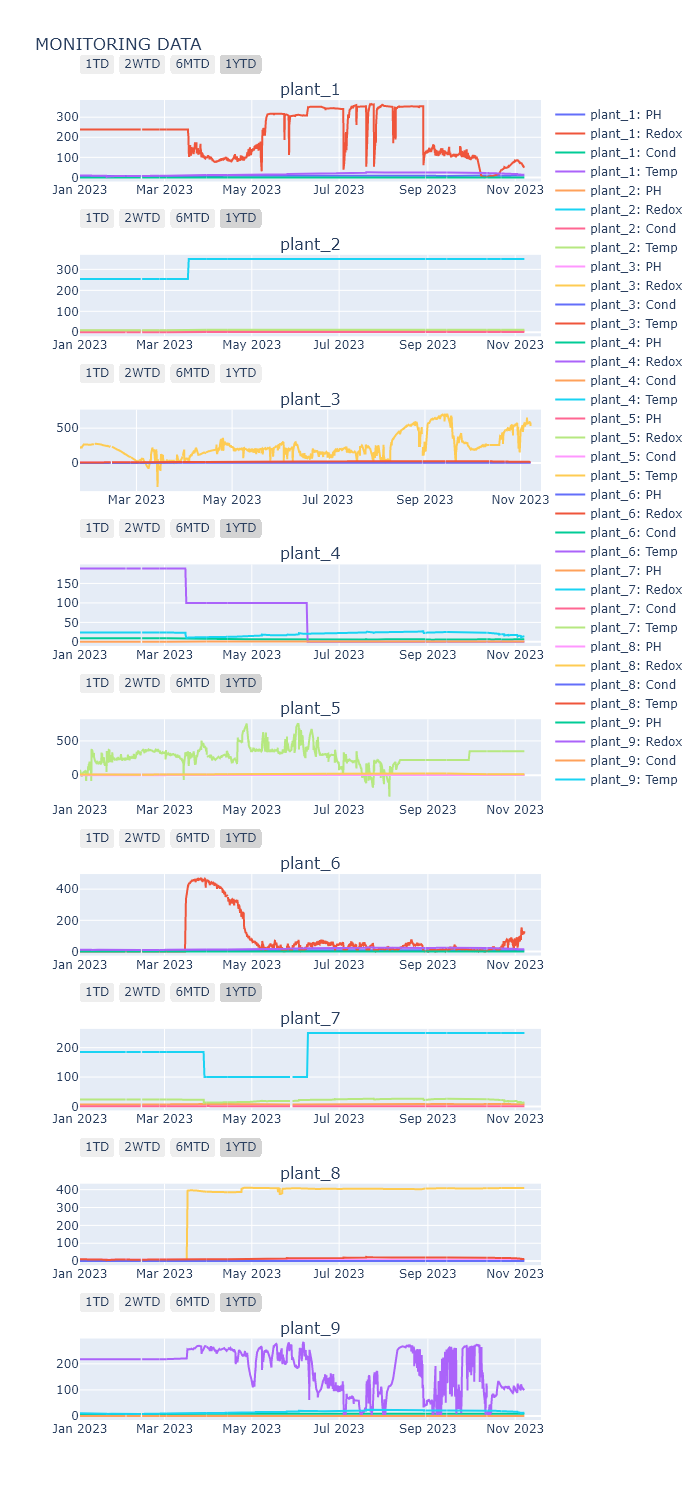

In [23]:
plot_plant = ["all"] #all

plant=[]
for i in range(9):
    plant.append("plant_"+str(i+1))


if plot_plant==["all"]:
    plot_plant=plant

v = []
for i, e in enumerate (plant):
    if e in plot_plant:
        v.append (i)
        
height=1500 #plot height


time_buttons = [
    {'count': 1, 'step': 'day', 'stepmode': 'todate', 'label': '1TD'},
    {'count': 14, 'step': 'day', 'stepmode': 'todate', 'label': '2WTD'},
    {'count': 6, 'step': 'month', 'stepmode': 'todate', 'label': '6MTD'},
    {'count': 1, 'step': 'year', 'stepmode': 'todate', 'label': '1YTD'}
]

fig_imp = make_subplots(rows=9, cols=1, subplot_titles=tuple(plot_plant))
column_headers = list(data[v[0]].columns) 

for i in range(9):
    for ii in range(1,len(column_headers)):
        df=data[v[i]].copy()
        fig_imp.add_trace(go.Scatter(x=df[column_headers[0]], y=df[column_headers[ii]], name=plot_plant[i]+": "+column_headers[ii]), #mode='lines+markers'),
        row=i+1, col=1)
fig_imp.update_layout(height=height)  
fig_imp.update_layout(title_text='MONITORING DATA') 

fig_imp.update_xaxes(rangeselector={'buttons': time_buttons})
fig_imp.write_image("images/fig1.png")
fig_imp.show("png")

Plot monitoring data, one graph for each sensor type: there are 4 sensors, pH, temperature, condictivity and redox potential. Flat lines represents lost signal, which will be detected and deleted later on in the code

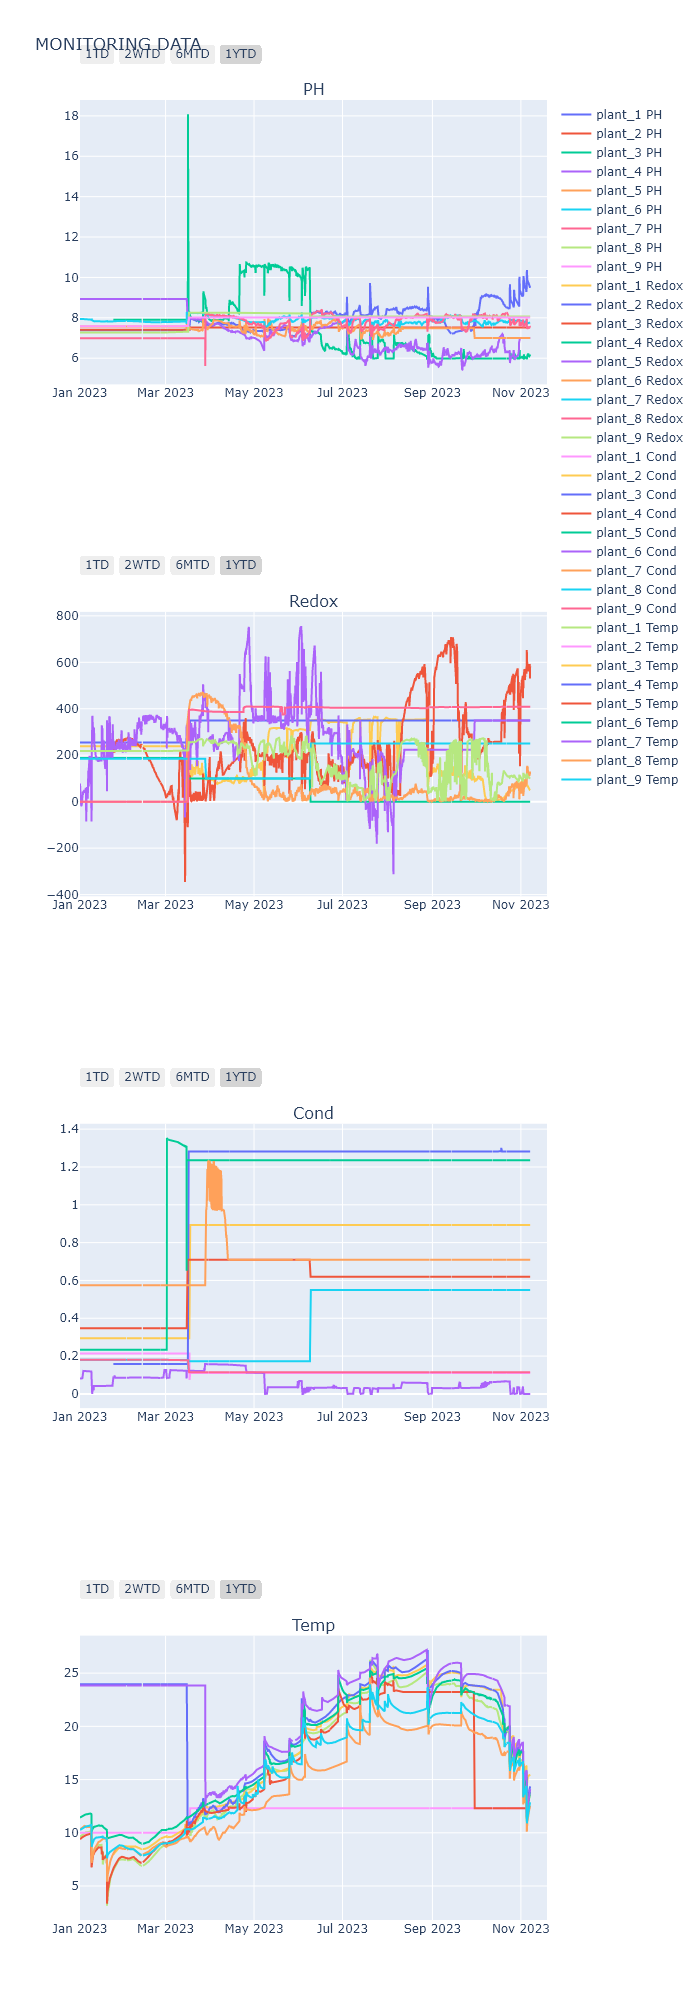

In [10]:
height=2000 #plot height

column_headers = list(data[v[0]].columns)

fig_par = make_subplots(rows=len(data[v[0]].columns)-1, cols=1, subplot_titles=tuple(data[v[0]].columns.drop("Datetime")))

for i in range(0,len(column_headers)-1):
    for ii in range(0,len(v)):
        df=data[v[ii]].copy() #read plant
        second_line = go.Scatter(x=df[column_headers[0]], y=df[column_headers[i+1]], name=plot_plant[ii]+" "+column_headers[i+1]) #mode='lines+markers')
                                    #legendgroup = i)
        fig_par.append_trace(second_line, row=i+1, col=1)

fig_par.update_layout(height=height, title_text='MONITORING DATA')
fig_par.update_xaxes(rangeselector={'buttons': time_buttons})
fig_par.write_image("images/fig2.png")
fig_par.show("png")

## Data cleaning

For each sensor type and monitoring station, delect and delete flat signal: we can observe that several monitoring stations have sensors with flat signal which are not working as expected. The following table shows the data removed from the dataframe

In [12]:
data_clean={}

report = {'Plant': [], 
        'Sensor': [],
        'Cells cleaned': [],
        'Cells cleaned %': []}
report = pd.DataFrame(report) 
report_count=0

for i in range(len(plant)):
    data_clean[i]=data[i].copy()

    for a in range(data_clean[i].shape[1]-1):

        df = pd.DataFrame({'Datetime': data_clean[i].iloc[:,0],
                        'First': data_clean[i].iloc[:,a+1],
                        'Second': data_clean[i].iloc[:,a+1]})
        df['Second'] = df['Second'].shift(1)
        df['check'] = np.where((df['First'] == df['Second']),1, 0)
        df.drop(df[df['check'] ==0].index, inplace = True)
        ind=df.index
        data_clean[i].iloc[ind,a+1] = np.NaN

    column_headers = list(data_clean[i].columns.values)

    for a in range(data_clean[i].shape[1]-1):
        rows_count = len(data_clean[i].index)
        count=data_clean[i].iloc[:,a+1].isna().sum()
        report.loc[report_count] = [plant[i], column_headers[a+1], data_clean[i].iloc[:,a+1].isna().sum(), round(count/rows_count*100)]
        report_count=report_count+1
report

,Plant,Sensor,Cells cleaned,Cells cleaned %
0,plant_1,PH,1890,27
1,plant_1,Redox,2518,36
2,plant_1,Cond,6890,100
3,plant_1,Temp,302,4
4,plant_2,PH,6886,100
5,plant_2,Redox,6886,100
6,plant_2,Cond,6885,100
7,plant_2,Temp,6886,100
8,plant_3,PH,2472,39
9,plant_3,Redox,358,6


Plot, for each monitoring station, sensors data cleaned from the dataframe: we can observe that, for plant_2, all sensors are not working properly 

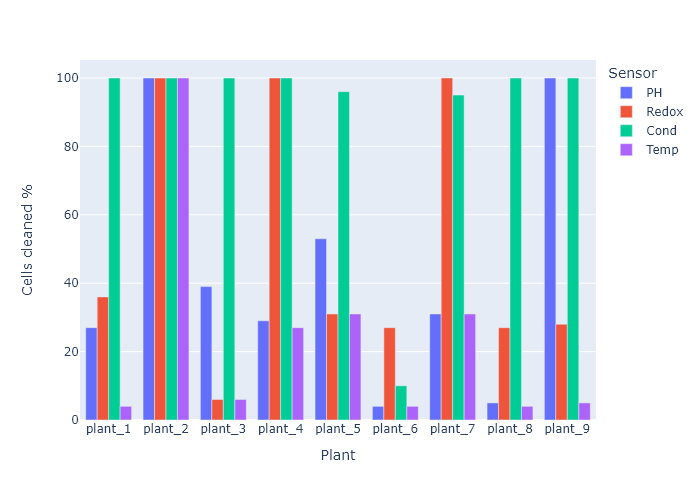

In [13]:
fig = px.bar(report, x='Plant', y='Cells cleaned %',color="Sensor", barmode='group')
fig.write_image("images/fig3.png")
fig.show("png")

Plot, for each sensor, the monitoring data cleaned from the dataframe: we can observe that most conductivity sensors are not working properly 

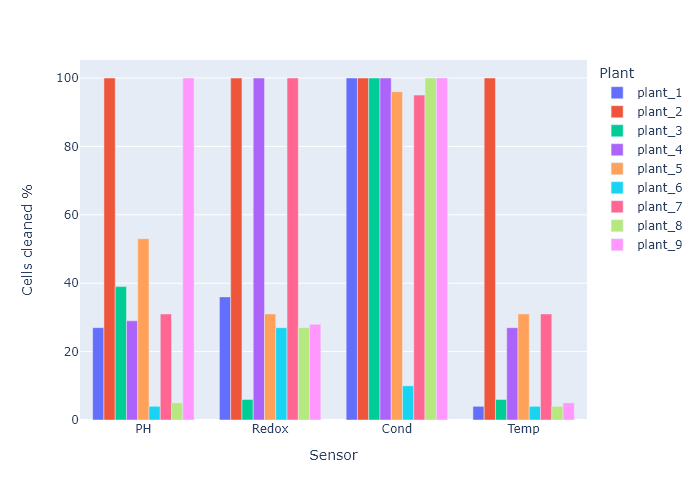

In [14]:
fig = px.bar(report, x='Sensor', y='Cells cleaned %',color="Plant", barmode='group')
fig.write_image("images/fig4.png")
fig.show("png")

### Plot cleaned data

Plot cleaned monitoring data, one graph for each monitoring station

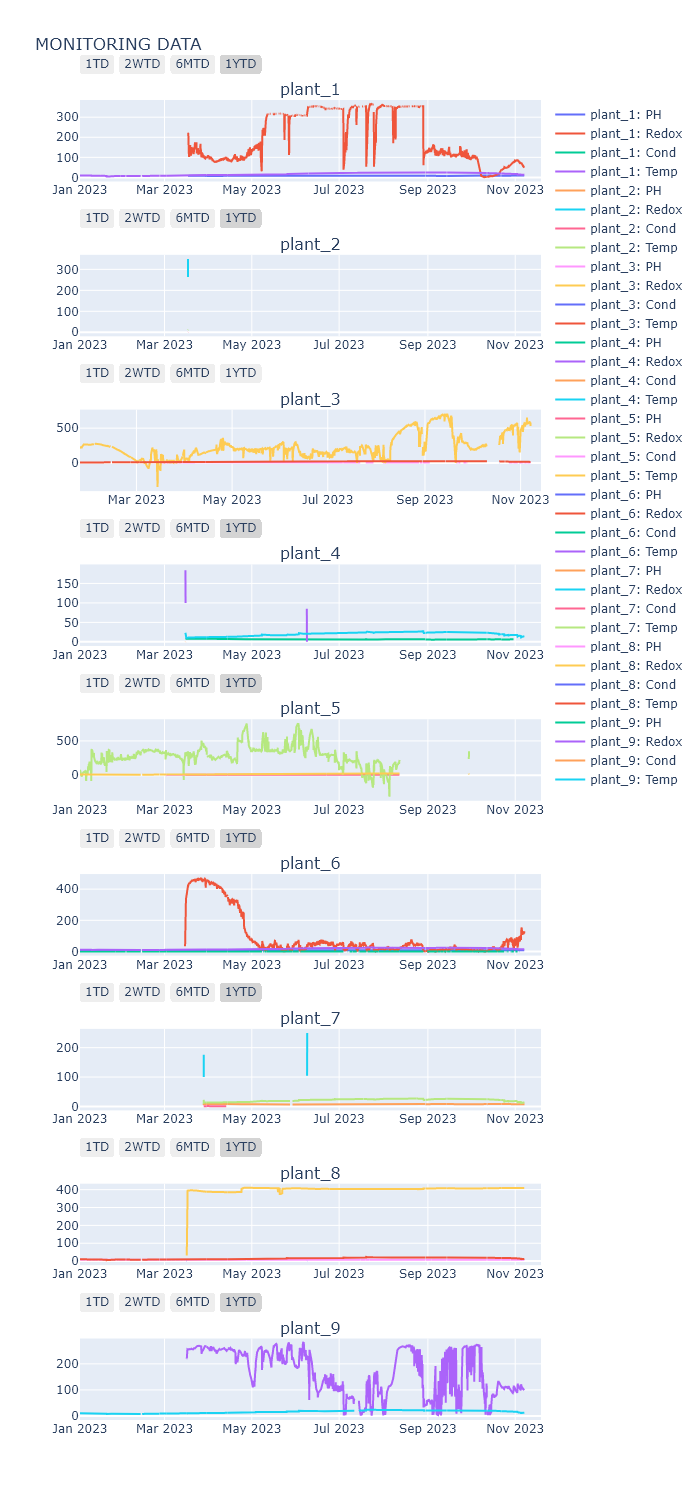

In [15]:
height=1500 #plot height

for i in range(len(plant)):
    data[i]=data_clean[i].copy()
    
fig_cleaned = make_subplots(rows=len(v), cols=1, subplot_titles=tuple(plot_plant))
column_headers = list(data[v[0]].columns) 

for i in range(0,len(v)):
    for ii in range(1,len(column_headers)):
        df=data[v[i]].copy()
        fig_cleaned.add_trace(go.Scatter(x=df[column_headers[0]], y=df[column_headers[ii]], name=plot_plant[i]+": "+column_headers[ii]), #mode='lines+markers'),
        row=i+1, col=1)    
fig_cleaned.update_layout(height=height)  
fig_cleaned.update_layout(title_text='MONITORING DATA') 
fig_cleaned.update_xaxes(rangeselector={'buttons': time_buttons})
fig_cleaned.write_image("images/fig5.png")
fig_cleaned.show("png")

Plot cleaned monitoring data, one graph for each sensor type

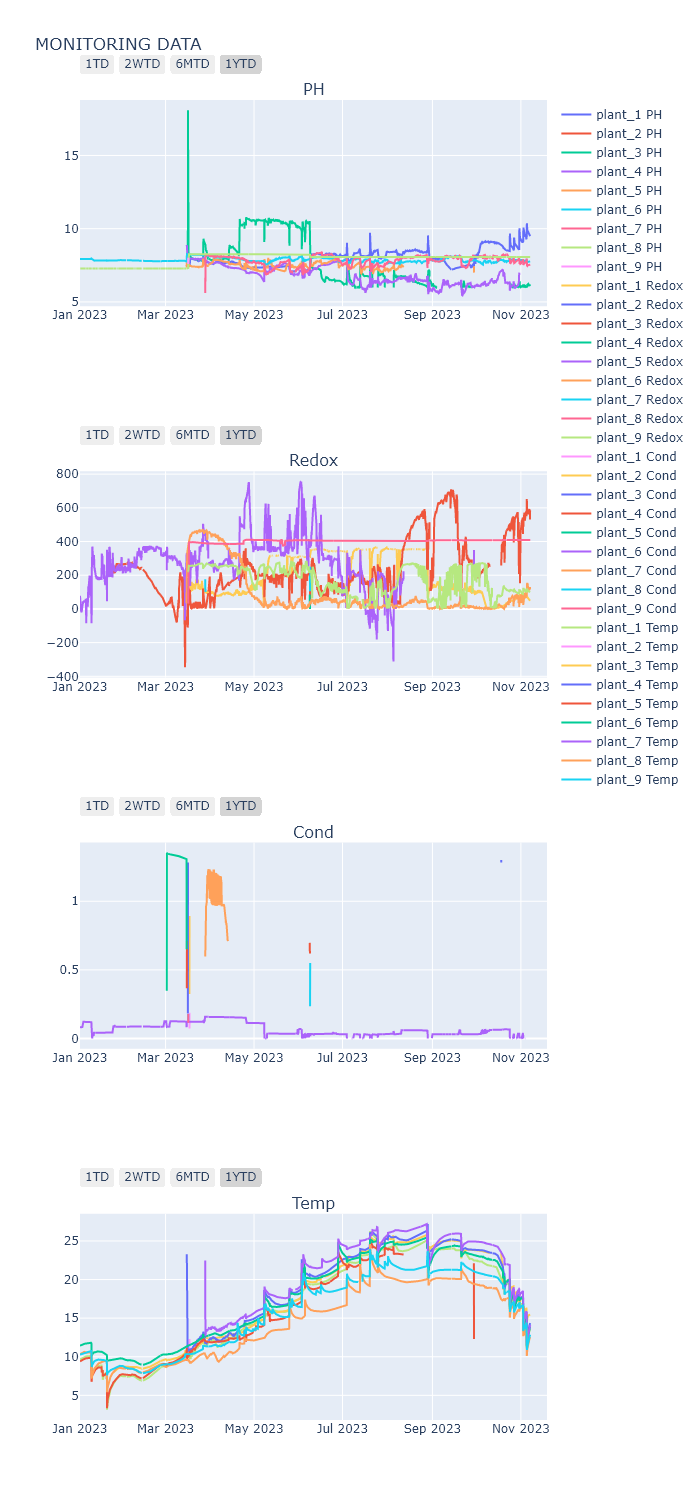

In [16]:
column_headers = list(data[v[0]].columns)

fig = make_subplots(rows=len(data[v[0]].columns)-1, cols=1, subplot_titles=tuple(data[v[0]].columns.drop("Datetime")))

for i in range(0,len(column_headers)-1):
    for ii in range(0,len(v)):
        df=data[v[ii]].copy() #read plant
        second_line = go.Scatter(x=df[column_headers[0]], y=df[column_headers[i+1]], name=plot_plant[ii]+" "+column_headers[i+1]) #, mode='lines+markers')
                                    #legendgroup = i)
        fig.append_trace(second_line, row=i+1, col=1)
        
height=1500
fig.update_layout(height=height, title_text='MONITORING DATA')
fig.update_xaxes(rangeselector={'buttons': time_buttons})
fig.write_image("images/fig6.png")
fig.show("png")

### Statistics

The following table and graph summarise some statistics regarding the sensors installed within the monitoring stations

In [17]:
c={}
value_d={}
nan_d={}
c = pd.DataFrame({'Plant': [], 
        'All sensors ON %': [],
        'All sensors OFF %': [],
        'At least 1 sensor ON %': [],
        'At least 1 sensor OFF %': []
        })

for i in range(9):
    value_d[i] = ~data[i].drop(['Datetime'], axis=1).isna() #True=existing value, axis=0 along rows, axis=1 along columns
    nan_d[i] = data[i].drop(['Datetime'], axis=1).isna() #True=NaN, axis=0 along rows, axis=1 along columns
    new_line = pd.DataFrame({'Plant': [plot_plant[i]], 
        'All sensors ON %':  [round(sum(value_d[i].all(axis=1))/data[i].shape[0]*100,2)],
        'All sensors OFF %': [round(sum(nan_d[i].all(axis=1))/data[i].shape[0]*100,2)],
        'At least 1 sensor ON %': [round(sum(value_d[i].any(axis=1))/data[i].shape[0]*100,2)],
        'At least 1 sensor OFF %': [round((sum(nan_d[i].any(axis=1))/data[i].shape[0])*100,2)]})
    c = pd.concat([c, new_line])
c

,Plant,All sensors ON %,All sensors OFF %,At least 1 sensor ON %,At least 1 sensor OFF %
0,plant_1,0.22,4.36,95.64,99.78
0,plant_2,0.22,99.77,0.23,99.78
0,plant_3,0.24,5.52,94.48,99.76
0,plant_4,0.25,26.71,73.29,99.75
0,plant_5,0.22,30.85,69.15,99.78
0,plant_6,68.14,4.13,95.87,31.86
0,plant_7,0.23,31.15,68.85,99.77
0,plant_8,0.28,4.19,95.81,99.72
0,plant_9,0.20,5.12,94.88,99.80


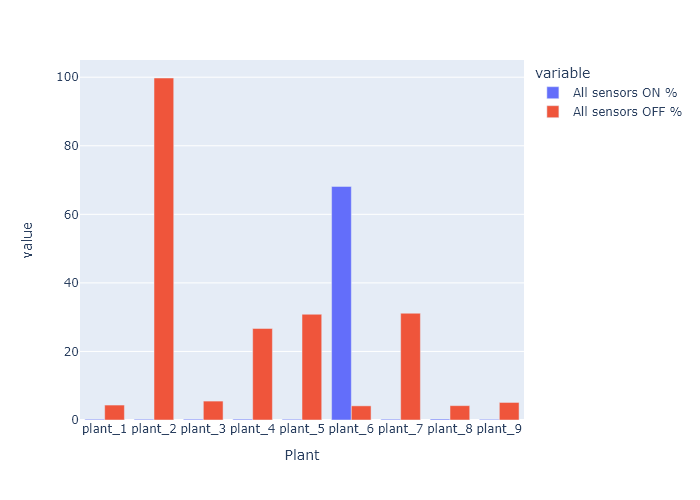

In [18]:
fig = px.bar(c, x='Plant', y=['All sensors ON %','All sensors OFF %'],barmode='group')
fig.write_image("images/fig7.png")
fig.show("png")

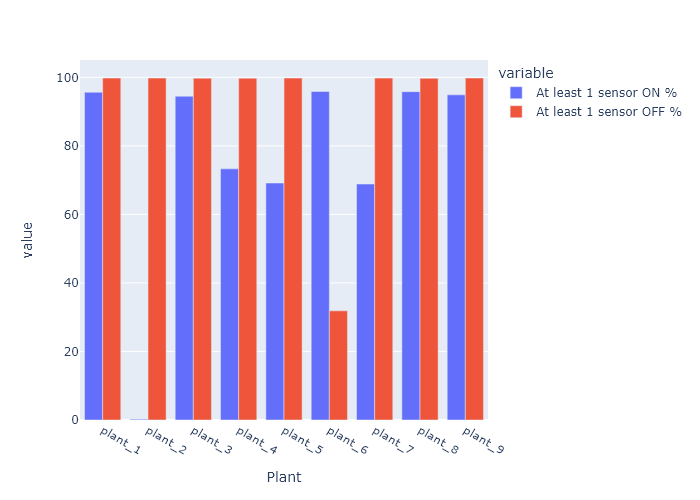

In [19]:
fig = px.bar(c, x='Plant', y=['At least 1 sensor ON %','At least 1 sensor OFF %'],barmode='group')
fig.write_image("images/fig8.png")
fig.show("png")